## Applying Logistic Regression Towards Exploring Hand-written Digits (MNIST dataset)

To demonstrate the ML principles on a more interesting problem, let's consider one piece of the optical character recognition problem: the identification of hand-written digits. In the wild, this problem involves both locating and identifying characters in an image. Here we'll take a shortcut and use Scikit-Learn's set of pre-formatted digits, which is built into the library.

### Loading and visualizing the digits data

We'll use Scikit-Learn's data access interface and take a look at this data:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the data
digits = load_digits()
digits.images.shape

(1797, 8, 8)

In [2]:
# Take a look at some of the data
import numpy as np
digits.images[:5,:,:]

array([[[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
        [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
        [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
        [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
        [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
        [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
        [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
        [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.],
        [ 0.,  0.,  0., 11., 16.,  9.,  0.,  0.],
        [ 0.,  0.,  3., 15., 16.,  6.,  0.,  0.],
        [ 0.,  7., 15., 16., 16.,  2.,  0.,  0.],
        [ 0.,  0.,  1., 16., 16.,  3.,  0.,  0.],
        [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
        [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
        [ 0.,  0.,  0., 11., 16., 10.,  0.,  0.]],

       [[ 0.,  0.,  0.,  4., 15., 12.,  0.,  0.],
        [ 0.,  0.,  3., 16., 15., 14.,  0.,  0.],
        [ 0.,  0.,  8., 13.,  8., 16.,  0.,  0.],
        [ 0.,  0.,  1.,  6., 15., 11.,  0.,  0

More info on a related dataset:
http://yann.lecun.com/exdb/mnist/

The images data is a three-dimensional array: 1,797 samples each consisting of an 8 × 8 grid of pixels.
Let's visualize the first hundred of these:

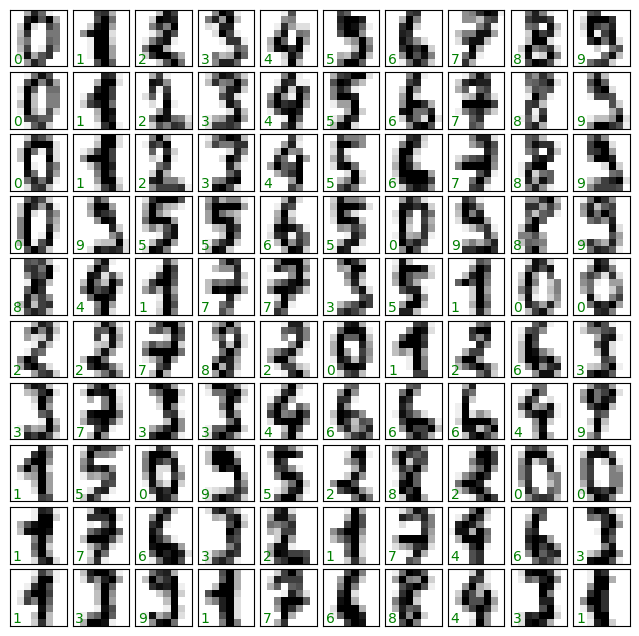

In [3]:
# Visualize some of the data

fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')

In order to work with this data within Scikit-Learn, we need a two-dimensional, ``[n_samples, n_features]`` representation.

We can accomplish this by treating each pixel in the image as a feature: that is, by flattening out the pixel arrays so that we have a length-64 array of pixel values representing each digit.

Additionally, we need the target array, which gives the previously determined label for each digit.
These two quantities are built into the digits dataset under the ``data`` and ``target`` attributes, respectively:

In [4]:
X = digits.data

### Your code here: Get the shape of data
### X.your_code
X.shape

(1797, 64)

In [5]:
y = digits.target

### Your code here: Get the shape of targets
### y.your_code
y.shape

(1797,)

We see here that there are 1,797 samples and 64 features.

### Unsupervised learning: Dimensionality reduction

We'd like to visualize our points within the 64-dimensional parameter space, but it's difficult to effectively visualize points in such a high-dimensional space.

Instead we'll reduce the dimensions to 2, using an unsupervised method.
Here, we'll make use of principal component analysis (PCA) and transform the data to two dimensions:

In [6]:
# Initialize PCA with n_components=2, reducing the data to 2 dimensions.

### Your code here: Apply the PCA() function along with the n_components = 2
### pca = your_code
pca = PCA(n_components=2)

# Fit PCA to the data and transform it
# fit_transform() combines fitting the PCA model to the data transforming the
# data into the lower-dimensional 2D space.
data_projected = pca.fit_transform(X)

# Check the shape of the projected data
print("Shape of data after PCA projection:", data_projected.shape)

# The variance ratio to see information retained by the two components
print(f"Explained variance by first two components: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

Shape of data after PCA projection: (1797, 2)
Explained variance by first two components: [0.14890594 0.13618771]
Total explained variance: 0.2851


We see that the projected data is now two-dimensional.
Let's plot this data to see if we can learn anything from its structure:

<ipython-input-7-c493a50968fa>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('jet', 10))


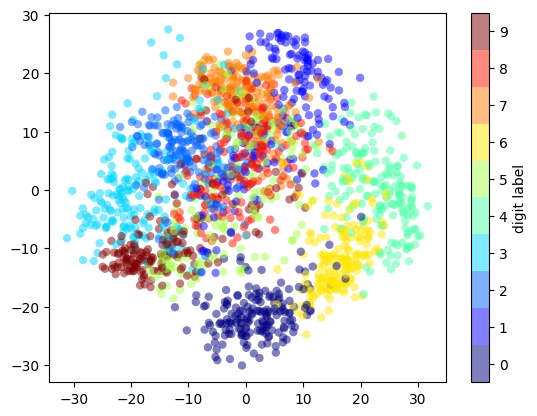

In [7]:
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=digits.target,
            edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5);

This plot gives us some good intuition into how well various numbers are separated in the larger 64-dimensional space.

Overall, however, the different groups appear to be fairly well separated in the parameter space: this tells us that even a very straightforward supervised classification algorithm should perform suitably on this data.
Let's give it a try.

### Classification on digits

Let's apply a classification algorithm to the digits.
As with the Iris data previously, we will split the data into a training and testing set, and fit a Gaussian naive Bayes model:

In [8]:
# Split the data into 75% train / 25% test using train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

In [10]:
# Create a LogisticRegression model and fit it on training data

### Your code here: Apply the LogisticRegression() function
### model = your_code
model = LogisticRegression(max_iter=1000)

model.fit(Xtrain, ytrain)

# Test model performance on a held-out dataset.

### Your code here: Apply the predict() function and Xtest as parameter
### y_model = model.your_cde
y_model = model.predict(Xtest)


Now that we have predicted our model, we can gauge its accuracy by comparing the true values of the test set to the predictions:

In [12]:
### Your code here: Apply the accuracy_score() function
### along with ytest, y_model passed as parameters
### your_code
from sklearn.metrics import accuracy_score

accuracy_score(ytest, y_model)

0.9533333333333334

With even this extremely simple model, we find about 80% accuracy for classification of the digits!

However, this single number doesn't tell us *where* we've gone wrong—one nice way to do this is to use the *confusion matrix*, which we can compute with Scikit-Learn and plot with Seaborn:

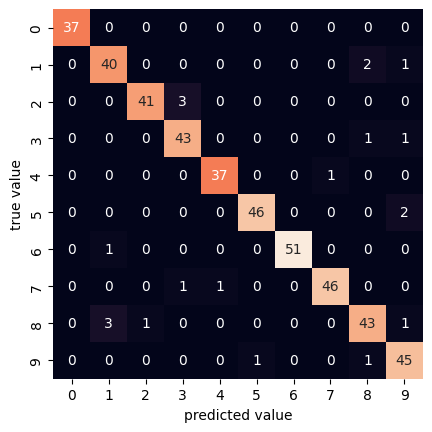

In [13]:
# Plot the confusion matrix

### Your code here: Apply the confusion_matrix() function
### along with ytest, y_model passed as parameters
### mat = your_code
mat = confusion_matrix(ytest, y_model)

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

This shows us where the mis-labeled points tend to be: for example, a large number of twos here are mis-classified as either ones or eights. Another way to gain intuition into the characteristics of the model is to plot the inputs again, with their predicted labels. We'll use green for correct labels, and red for incorrect labels:

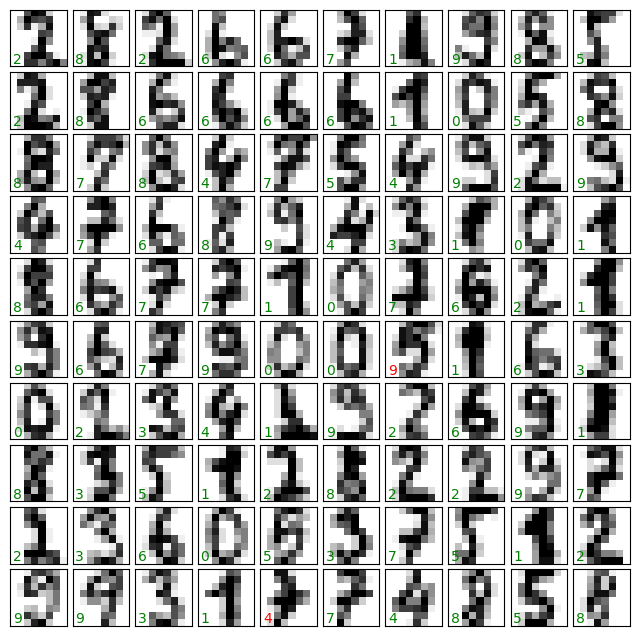

In [14]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 8, 8)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(y_model[i]),
            transform=ax.transAxes,
            color='green' if (ytest[i] == y_model[i]) else 'red')